In [80]:
import os
import datetime as dt
import requests
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()

SUPABASE_URL = os.environ.get("SUPABASE_URL")
SUPABASE_KEY = (
    os.environ.get("SUPABASE_SERVICE_ROLE_KEY")
    or os.environ.get("SUPABASE_API_KEY")
    or os.environ.get("SUPABASE_ANON_KEY")
)

if not SUPABASE_URL or not SUPABASE_KEY:
    raise RuntimeError("Set SUPABASE_URL and SUPABASE_KEY in environment.")

In [81]:
def fetch_macro_state_daily(start_date: dt.date, end_date: dt.date) -> pd.DataFrame:
    endpoint = f"{SUPABASE_URL}/rest/v1/macro_state_daily"
    headers = {
        "apikey": SUPABASE_KEY,
        "Authorization": f"Bearer {SUPABASE_KEY}",
    }
    params_base = {
        "select": ",".join(
            [
                "date",
                "regime_id",
                "regime_label",
                "stress_score",
                "hmm_score_0_100",
                "prob_state_0",
                "prob_state_1",
                "prob_state_2",
                "prob_state_3",
            ]
        ),
        "date": [f"gte.{start_date.isoformat()}", f"lte.{end_date.isoformat()}"],
        "order": "date.asc",
        "limit": 1000,
    }

    rows = []
    offset = 0
    while True:
        params = params_base.copy()
        params["offset"] = offset
        resp = requests.get(endpoint, headers=headers, params=params, timeout=30)
        resp.raise_for_status()
        batch = resp.json()
        rows.extend(batch)
        if len(batch) < 1000:
            break
        offset += 1000

    df = pd.DataFrame(rows)
    if df.empty:
        return df
    df["date"] = pd.to_datetime(df["date"])
    return df

In [82]:
end = dt.date.today()
start = end - dt.timedelta(days=365)

macro = fetch_macro_state_daily(start, end)
macro.head()

,date,regime_id,regime_label,stress_score,hmm_score_0_100,prob_state_0,prob_state_1,prob_state_2,prob_state_3
0,2025-01-23,3,Stagflation,0.000000,85.595260,0.000043,0.998800,1.461428e-09,0.001157
1,2025-01-24,3,Stagflation,0.000000,85.599780,0.000045,0.998483,1.478830e-09,0.001472
2,2025-01-27,3,Stagflation,0.542349,85.606917,0.000059,0.997965,1.477810e-09,0.001976
3,2025-01-28,3,Stagflation,0.000000,85.647805,0.000055,0.995138,1.429029e-09,0.004807
4,2025-01-29,3,Stagflation,0.155897,85.762850,0.000099,0.987092,1.291880e-09,0.012810


In [83]:
# fetch SPX (^GSPC) and align
# Using multi_level_index=False to avoid MultiIndex columns (yfinance >= 0.2)
spx = yf.download(
    "^GSPC", 
    start=start.isoformat(), 
    end=(end + dt.timedelta(days=1)).isoformat(), 
    progress=False,
    multi_level_index=False
)

spx = spx.rename(columns=str.lower)
spx = spx[["close"]].reset_index()
spx["date"] = pd.to_datetime(spx["Date"] if "Date" in spx.columns else spx["date"])
spx = spx[["date", "close"]].set_index("date").sort_index()

# normalize SPX to 100 at start
spx["spx_norm"] = 100.0 * spx["close"] / spx["close"].iloc[0]

if "date" in macro.columns:
    macro_indexed = macro.set_index("date").sort_index()
else:
    macro_indexed = macro.sort_index()
    
df = macro_indexed.join(spx[["spx_norm"]], how="inner")

df.head()

,regime_id,regime_label,stress_score,hmm_score_0_100,prob_state_0,prob_state_1,prob_state_2,prob_state_3,spx_norm
date,,,,,,,,,
2025-01-23,3,Stagflation,0.000000,85.595260,0.000043,0.998800,1.461428e-09,0.001157,100.000000
2025-01-24,3,Stagflation,0.000000,85.599780,0.000045,0.998483,1.478830e-09,0.001472,99.714487
2025-01-27,3,Stagflation,0.542349,85.606917,0.000059,0.997965,1.477810e-09,0.001976,98.260578
2025-01-28,3,Stagflation,0.000000,85.647805,0.000055,0.995138,1.429029e-09,0.004807,99.166331
2025-01-29,3,Stagflation,0.155897,85.762850,0.000099,0.987092,1.291880e-09,0.012810,98.702342


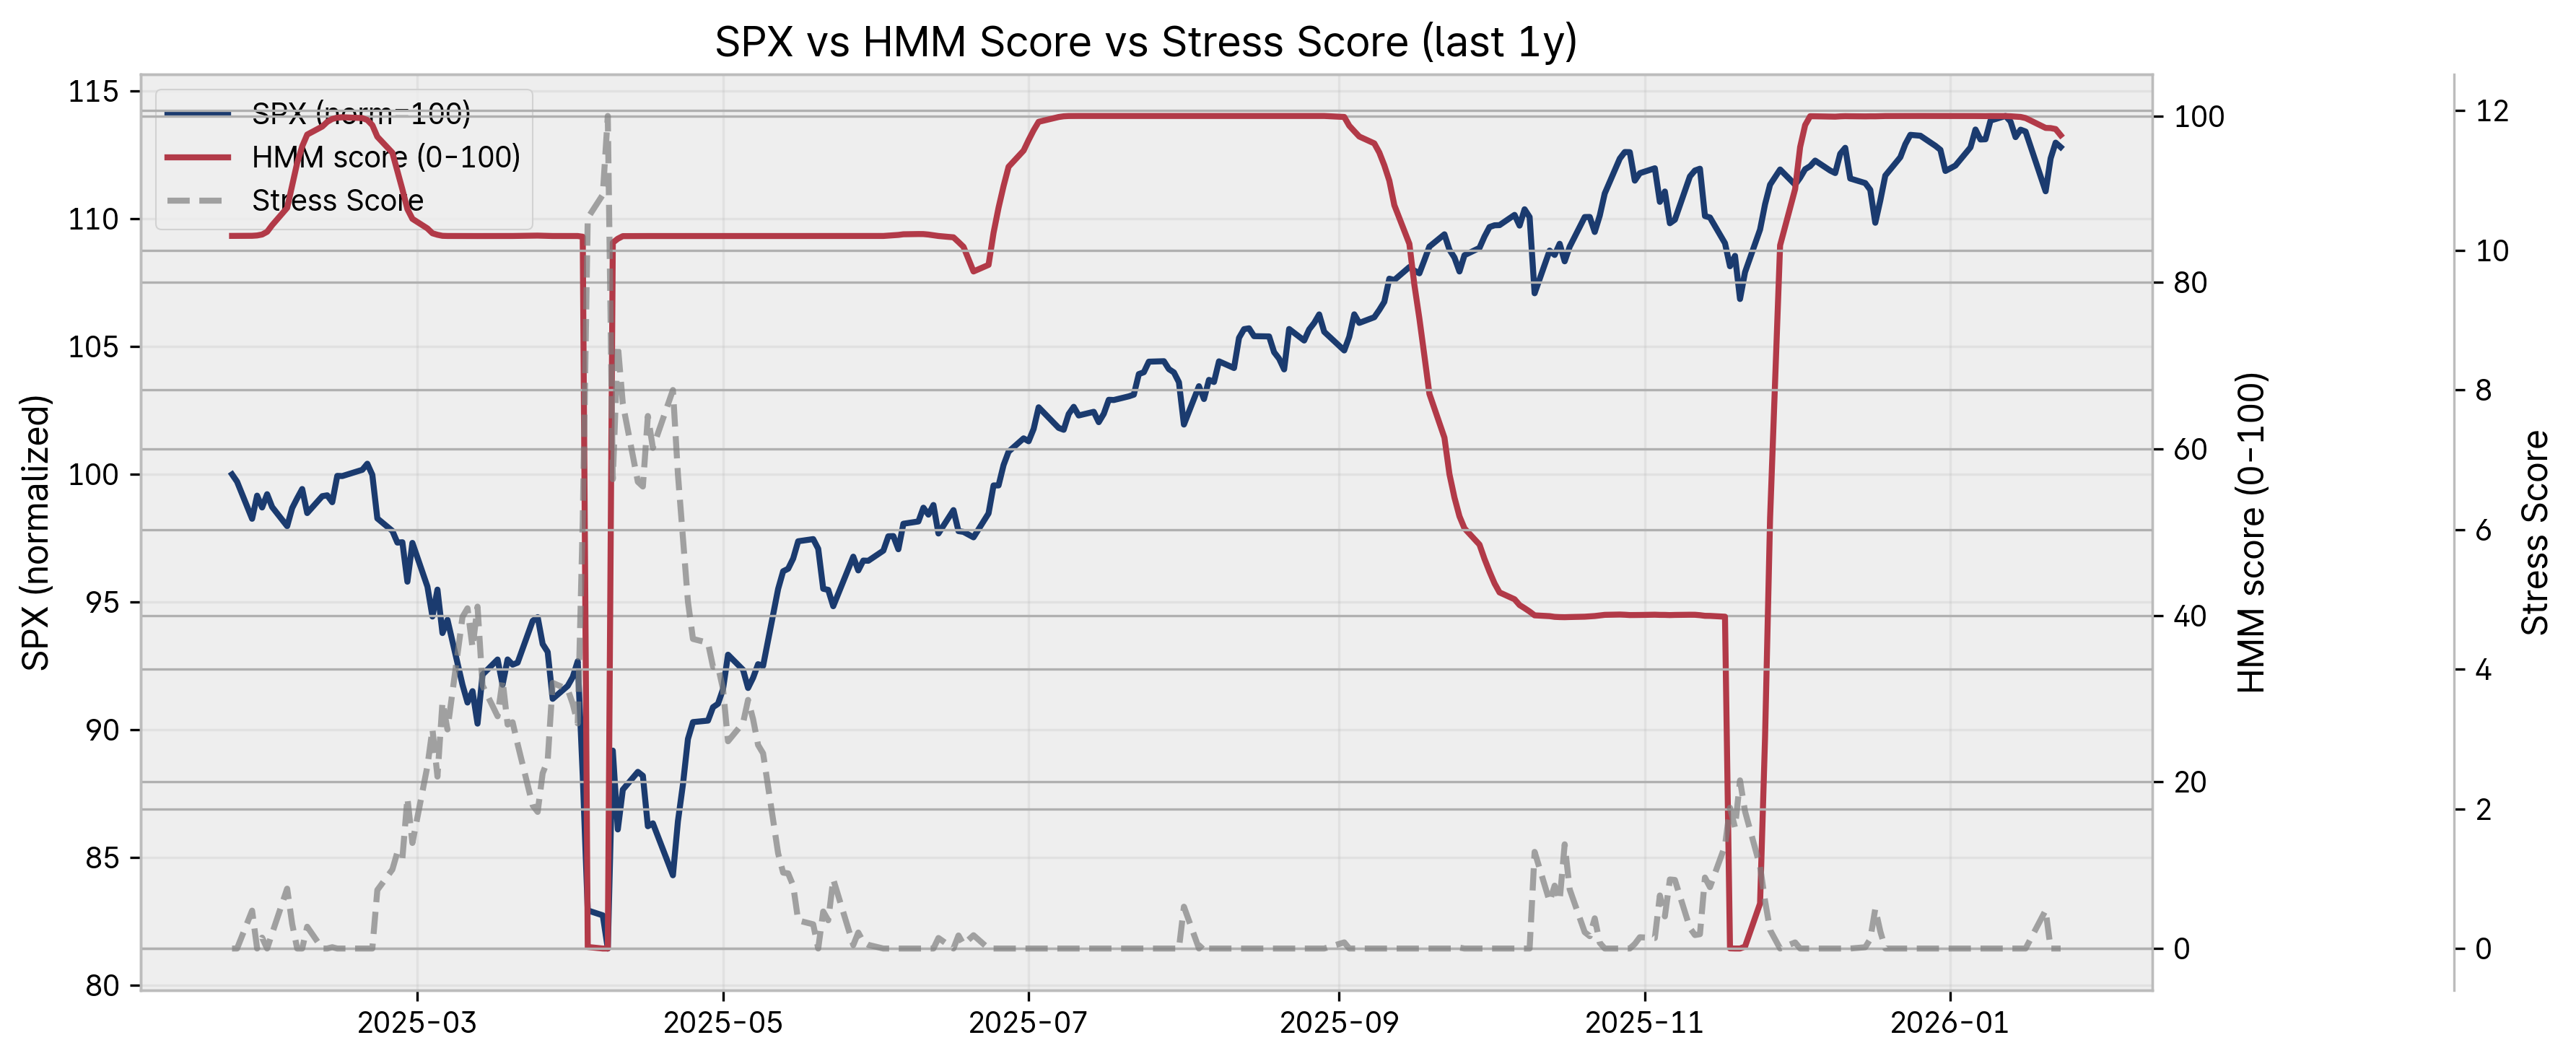

In [84]:
# plot SPX vs HMM score vs Stress Score
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(df.index, df["spx_norm"], color="#1b3b6f", label="SPX (norm=100)")
ax1.set_ylabel("SPX (normalized)")
ax1.set_title("SPX vs HMM Score vs Stress Score (last 1y)")
ax1.grid(True, alpha=0.2)

ax2 = ax1.twinx()
ax2.plot(df.index, df["hmm_score_0_100"], color="#b23a48", label="HMM score (0-100)")
ax2.set_ylabel("HMM score (0-100)")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.15))
ax3.plot(df.index, df["stress_score"], color="gray", linestyle="--", label="Stress Score", alpha=0.7)
ax3.set_ylabel("Stress Score")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc="upper left")

plt.tight_layout()
plt.show()

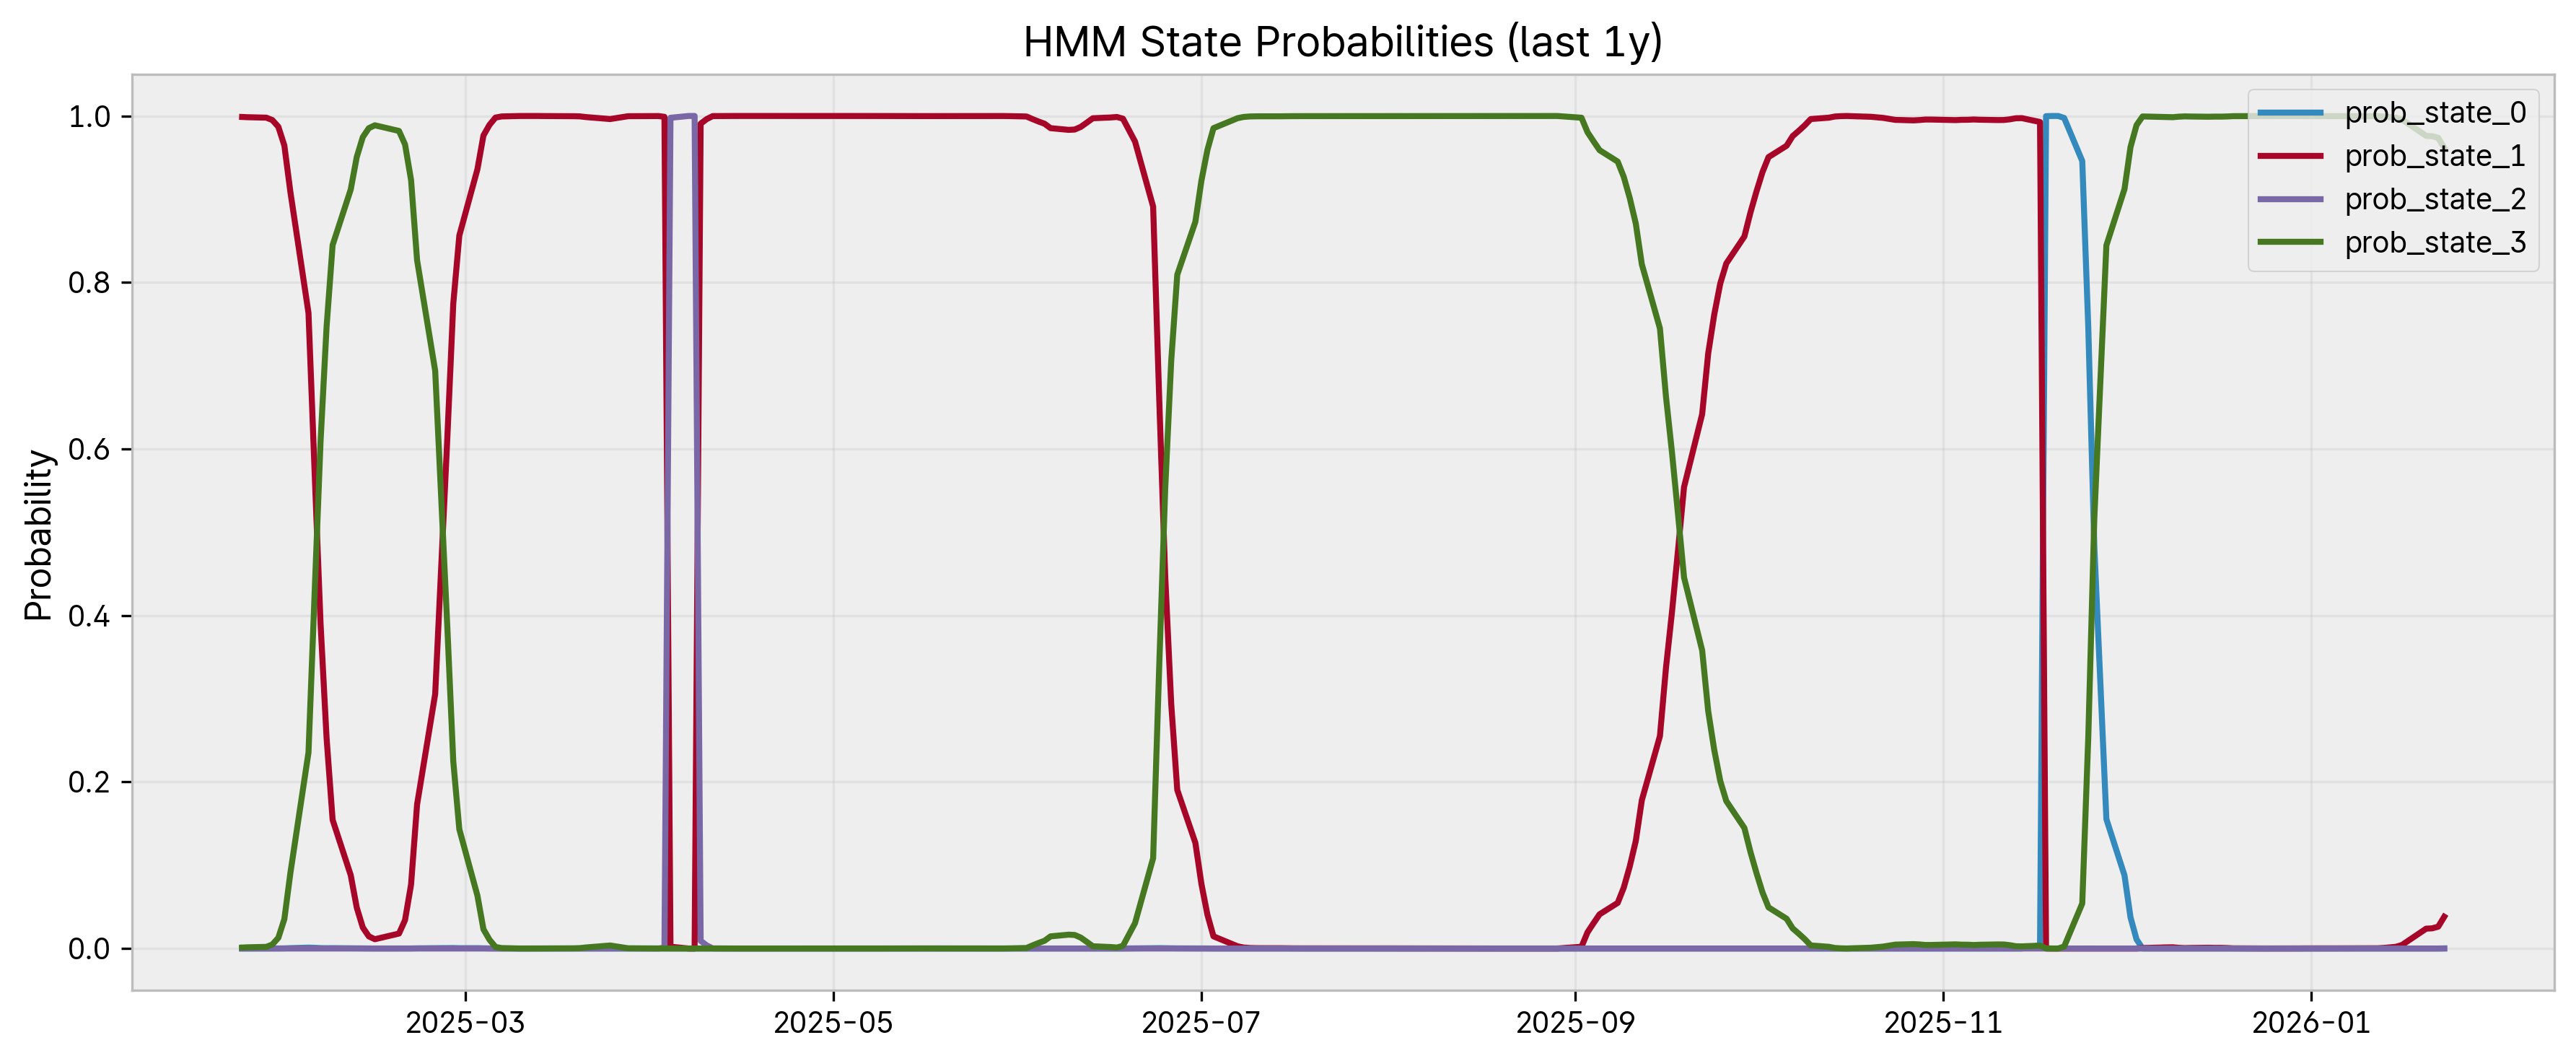

In [85]:
# plot prob_state lines
plt.figure(figsize=(12, 5))
for k in range(4):
    col = f"prob_state_{k}"
    if col in df.columns:
        plt.plot(df.index, df[col], label=col)

plt.title("HMM State Probabilities (last 1y)")
plt.ylabel("Probability")
plt.grid(True, alpha=0.2)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()